# 1. Community detection

### Class for saving twitter data to `networkx` graph

In [98]:
tweets_df

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,2.532612e+09,kathiemrr,1.488207e+12,2017-02-27 14:54:00,NaN,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,8.362279e+17,NaN,"[""ThingsDoneByMistake""]",[],POSTED,[],NaN,NaN
1,2.531160e+09,traceyhappymom,1.471273e+12,2016-08-15 14:50:20,NaN,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,7.651989e+17,NaN,"[""TheOlderWeGet""]",[],POSTED,[],NaN,NaN
2,NaN,evewebster373,1.435701e+12,2015-06-30 21:56:09,NaN,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,6.160023e+17,NaN,[],[],POSTED,[],NaN,NaN
3,4.840552e+09,blacktolive,1.474013e+12,2016-09-16 08:04:48,18.0,False,17.0,Amen! #blacklivesmatter https://t.co/wGffaOqgzl,7.766933e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""Blacklivesmatter""]",[],POSTED,[],NaN,NaN
4,1.694026e+09,jacquelinisbest,1.474228e+12,2016-09-18 19:46:25,0.0,False,0.0,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,7.775946e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""WakeUpAmerica""]","[""http://ln.is/twitchy.com/loriz-31/3yafU""]",POSTED,"[""nahbabynah""]",7.775915e+17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203446,1.710805e+09,cookncooks,1.480735e+12,2016-12-03 03:16:17,NaN,NaN,NaN,RT @FairyTale_360: 6) Rexnord Bearings is set ...,8.048869e+17,NaN,[],[],POSTED,[],NaN,NaN
203447,2.928870e+09,newspeakdaily,1.475279e+12,2016-09-30 23:39:11,0.0,False,0.0,Will Trump’s Bad Week Hurt the GOP’s Senate Pr...,7.820019e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...","[""Politics""]",[],POSTED,[],NaN,NaN
203448,2.951556e+09,specialaffair,1.473072e+12,2016-09-05 10:45:09,0.0,False,0.0,"China blames United States, journalists for Ob...",7.727474e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...","[""news""]",[],POSTED,[],NaN,NaN
203449,2.671070e+09,patriotblake,1.486385e+12,2017-02-06 12:36:14,NaN,NaN,NaN,RT @bfraser747: 💥💥 #PresidentElectTrump \r\n\r...,8.285831e+17,NaN,[],[],POSTED,[],NaN,NaN


In [109]:
import networkx as nx
import pandas as pd
from networkx.algorithms import community

class GetTwitterNetwork:

    def get_user_network(self, tweets_df, directed=False):
        
        if directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()

        for _, row in tweets_df.iterrows():
            user_id = row['user_key']
            retweeted_status_id = row['retweeted_status_id']
            # map retweeted_status_id to user_key
            if pd.notnull(retweeted_status_id):
                user_id2 = tweets_df.loc[tweets_df['tweet_id'] == retweeted_status_id, 'user_key']

                if pd.isnull(user_id) or pd.isnull(user_id2) or user_id == user_id2:
                    continue
                
                else:
                    user_id2 = user_id2.values[0]
                    G.add_node(user_id)
                    G.add_node(user_id2)
                    G.add_edge(user_id, user_id2)
        
        return G
    
    def get_tweet_network(self, tweets_df, directed=False):
        
        if directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()

        for _, row in tweets_df.iterrows():
            tweet_id = row['tweet_id']
            in_reply_to_status_id = row['retweeted_status_id']

            # Add nodes and edges if the tweet is a reply to another tweet
            if (not pd.isnull(in_reply_to_status_id)) & (in_reply_to_status_id in tweets_df['tweet_id'].values):
                G.add_node(tweet_id)
                G.add_node(in_reply_to_status_id)
                G.add_edge(tweet_id, in_reply_to_status_id)
        
        return G

In [110]:
tweets_df = pd.read_csv("data/tweets.csv")
G = GetTwitterNetwork().get_user_network(tweets_df)

In [113]:
len(G.edges())

624

### Extract biggest connected component

In [114]:
connected_components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph containing only the largest connected component
G2 = G.subgraph(largest_component)
# unfreeze the graph
G2 = G2.to_undirected()

### Save its edges to `data/edges.csv`

In [115]:
edge_list = G2.edges()

# Convert the edge list to a DataFrame
df = pd.DataFrame(edge_list, columns=['Node1', 'Node2'])

# Save the DataFrame to a CSV file
df.to_csv('data/edges.csv', index=False)

### Detect communities, save only those with 1000 + nodes

In [124]:
communities = list(community.label_propagation_communities(G2))

In [125]:
communities = [com for com in communities if len(com) > 10]

### Save communities to csv format

In [ ]:
community_df = pd.DataFrame(columns=['id', 'community'])

# Populate the DataFrame with node IDs and their corresponding community
for community_id, community_nodes in enumerate(communities):
    community_df = community_df.append(pd.DataFrame({'id': list(community_nodes), 'community': [community_id for i in range(len(community_nodes))]}))

# Save the DataFrame to a CSV file
community_df.to_csv('data/communities.csv', index=False)

### Restrict network only to the nodes present in big communities

In [127]:
it = list(G2.nodes())
for g in it:
    assigned = False
    for i, c in enumerate(communities):
        if g in c:
            G2.nodes[g]['community'] = i
            assigned = True
    if not assigned:
        G2.remove_node(g)

### Count hashtags present in each community

In [130]:
community_words = {f'Community {i}': {} for i in range(len(communities))}
for i, c in enumerate(communities):    
    for g in c:
        user_hashtags = tweets_df[tweets_df.user_key == g]['hashtags']
        for hashtag_list in user_hashtags:
            if eval(hashtag_list):
                for h in eval(hashtag_list):
                    if h in community_words[f'Community {i}']:
                        community_words[f'Community {i}'][h] += 1
                    else:
                        community_words[f'Community {i}'][h] = 1

### Create dataframe of hashtag count in each community

In [ ]:
# create dataframe with community and hashtags
community_hashtags = pd.DataFrame(columns=['hashtag'] + [f'Community {i}' for i in range(len(community_words))])
# collect all hashtags
hashtags = []
for c in community_words:
    hashtags.extend(list(community_words[c].keys()))

# remove duplicates
hashtags = list(set(hashtags))

# for each hashtag, add the count for each community, if the hashtag is not in the community, add 0
for h in hashtags:
    community_hashtags = community_hashtags.append({'hashtag': h, 'Community 0': community_words['Community 0'].get(h, 0), 'Community 1': community_words['Community 1'].get(h, 0), 'Community 2': community_words['Community 2'].get(h, 0)}, ignore_index=True)


### Save to `hashtags_count.csv`

In [208]:
community_hashtags.to_csv('data/hashtag_count.csv', index=False)

In [213]:
# print community hashtags which have at least 100 count in one community
community_hashtags[(community_hashtags['Community 0'] > 500) | (community_hashtags['Community 1'] > 500) | (community_hashtags['Community 2'] > 500)]

,hashtag,Community 0,Community 1,Community 2
1184,IHaveARightToKnow,0,0,508
1714,pjnet,451,786,4
1923,TrumpPence16,514,394,20
2352,NeverHillary,766,530,26
2641,BetterAlternativeToDebates,1,0,545
3552,SurvivalGuideToThanksgiving,0,0,518
4324,maga,1693,1199,27
7012,ThingsYouCantIgnore,0,0,526
8305,RejectedDebateTopics,1,1,652
9214,tcot,817,1383,55


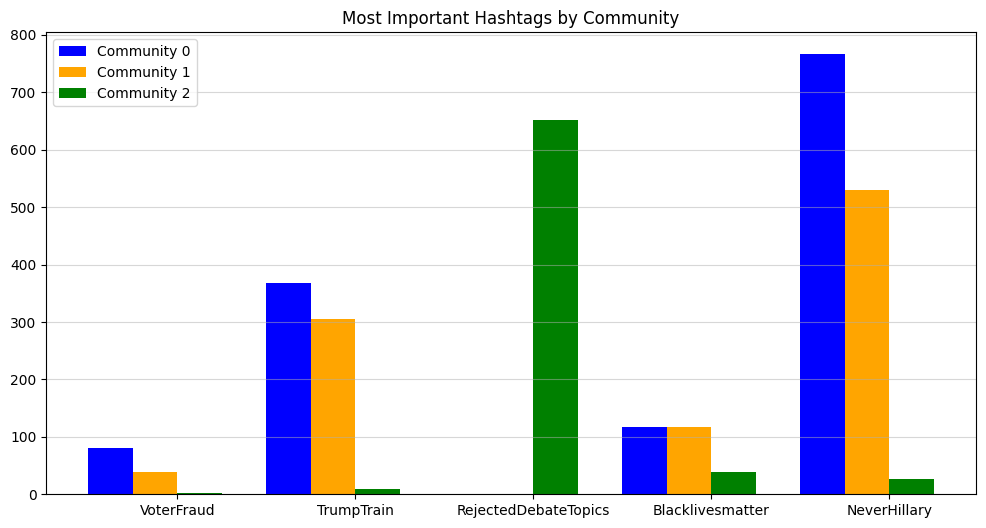

In [241]:
import matplotlib.pyplot as plt
import numpy as np

most_important_hashtags = ['VoterFraud', 'TrumpTrain', 'RejectedDebateTopics', 'Blacklivesmatter', 'NeverHillary']

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.25
bar_positions = np.arange(len(most_important_hashtags))

colors = ['blue', 'orange', 'green']

for community_idx, community in enumerate(['Community 0', 'Community 1', 'Community 2']):
    heights = [community_hashtags[community_hashtags['hashtag'] == h][community].values[0] for h in most_important_hashtags]

    ax.bar(bar_positions + community_idx * bar_width, heights, width=bar_width, label=f'{community}', color=colors[community_idx])

ax.set_title('Most Important Hashtags by Community')
ax.set_xticks(bar_positions + (len(most_important_hashtags) / 2 - 1) * bar_width)
ax.set_xticklabels(most_important_hashtags)
ax.legend()

plt.grid(axis='y', alpha=0.5)
plt.show()


# 1. Mapping user nodes to map of world

In [68]:
tweets_df = pd.read_csv("data/tweets.csv")

In [80]:
user_df = pd.read_csv('data/users.csv')

In [70]:
# get user_id and location where location is not null
user_location = user_df[['id','location']].dropna()
user_location

,id,location
0,1.003451e+08,still ⬆️Block⤵️Corner⬇️street
1,2.471657e+08,"Chicago, IL"
4,4.718689e+08,"Санкт-Петербург, Россия"
5,1.039581e+09,Amerika
6,1.510489e+09,USA
...,...,...
368,2.588789e+09,Москва
370,7.192812e+17,Islamic States of America
375,3.906962e+09,Paris
380,7.484650e+17,United States


In [ ]:
import requests


def get_geolocalization(location):

    url = f"https://nominatim.openstreetmap.org/search?q={location}&format=json&limit=1"

    try:
        response = requests.get(url, verify=False)
        data = response.json()
        
        if data:
            coordinates = (float(data[0]['lat']), float(data[0]['lon']))
            return coordinates
        else:
            return None
    except:
        return None
    

user_location['coordinates'] = user_location['location'].apply(get_geolocalization)

### Add `screen name` to the user_location.csv

In [145]:
user_location = pd.read_csv('data/user_location.csv')
user_location = pd.merge(user_location, user_df[['id', 'screen_name']], on='id', how='left')
user_location = user_location.rename(columns={'screen_name': 'user_key'})

In [147]:
user_location.to_csv('data/user_location.csv', index=False)

### Add community ids to nodes where possible

In [191]:
communities = pd.read_csv('data/communities.csv')
user_location = pd.read_csv('data/user_location.csv')
merged_df = user_location.merge(communities, left_on='user_key', right_on='id')

### Plot on the world map 

#### Without communities

In [192]:
user_location.dropna(inplace=True)
user_location['coordinates'] = user_location['coordinates'].apply(eval)

In [193]:
user_location

,id,location,coordinates,user_key
1,2.471657e+08,"Chicago, IL","(41.8755616, -87.6244212)",Beckster319
2,4.718689e+08,"Санкт-Петербург, Россия","(59.938732, 30.316229)",MargoSavazh
3,1.039581e+09,Amerika,"(53.6685061, 22.3069023)",darknally
4,1.510489e+09,USA,"(39.7837304, -100.445882)",lagonehoe
5,1.513801e+09,USA,"(39.7837304, -100.445882)",YouJustCtrlC
...,...,...,...,...
278,7.598250e+17,United States,"(39.7837304, -100.445882)",ChaNeutral
279,2.588789e+09,Москва,"(55.625578, 37.6063916)",gorelkinnn
281,3.906962e+09,Paris,"(48.8588897, 2.3200410217200766)",maximgaron1
282,7.484650e+17,United States,"(39.7837304, -100.445882)",PeeOnHillary


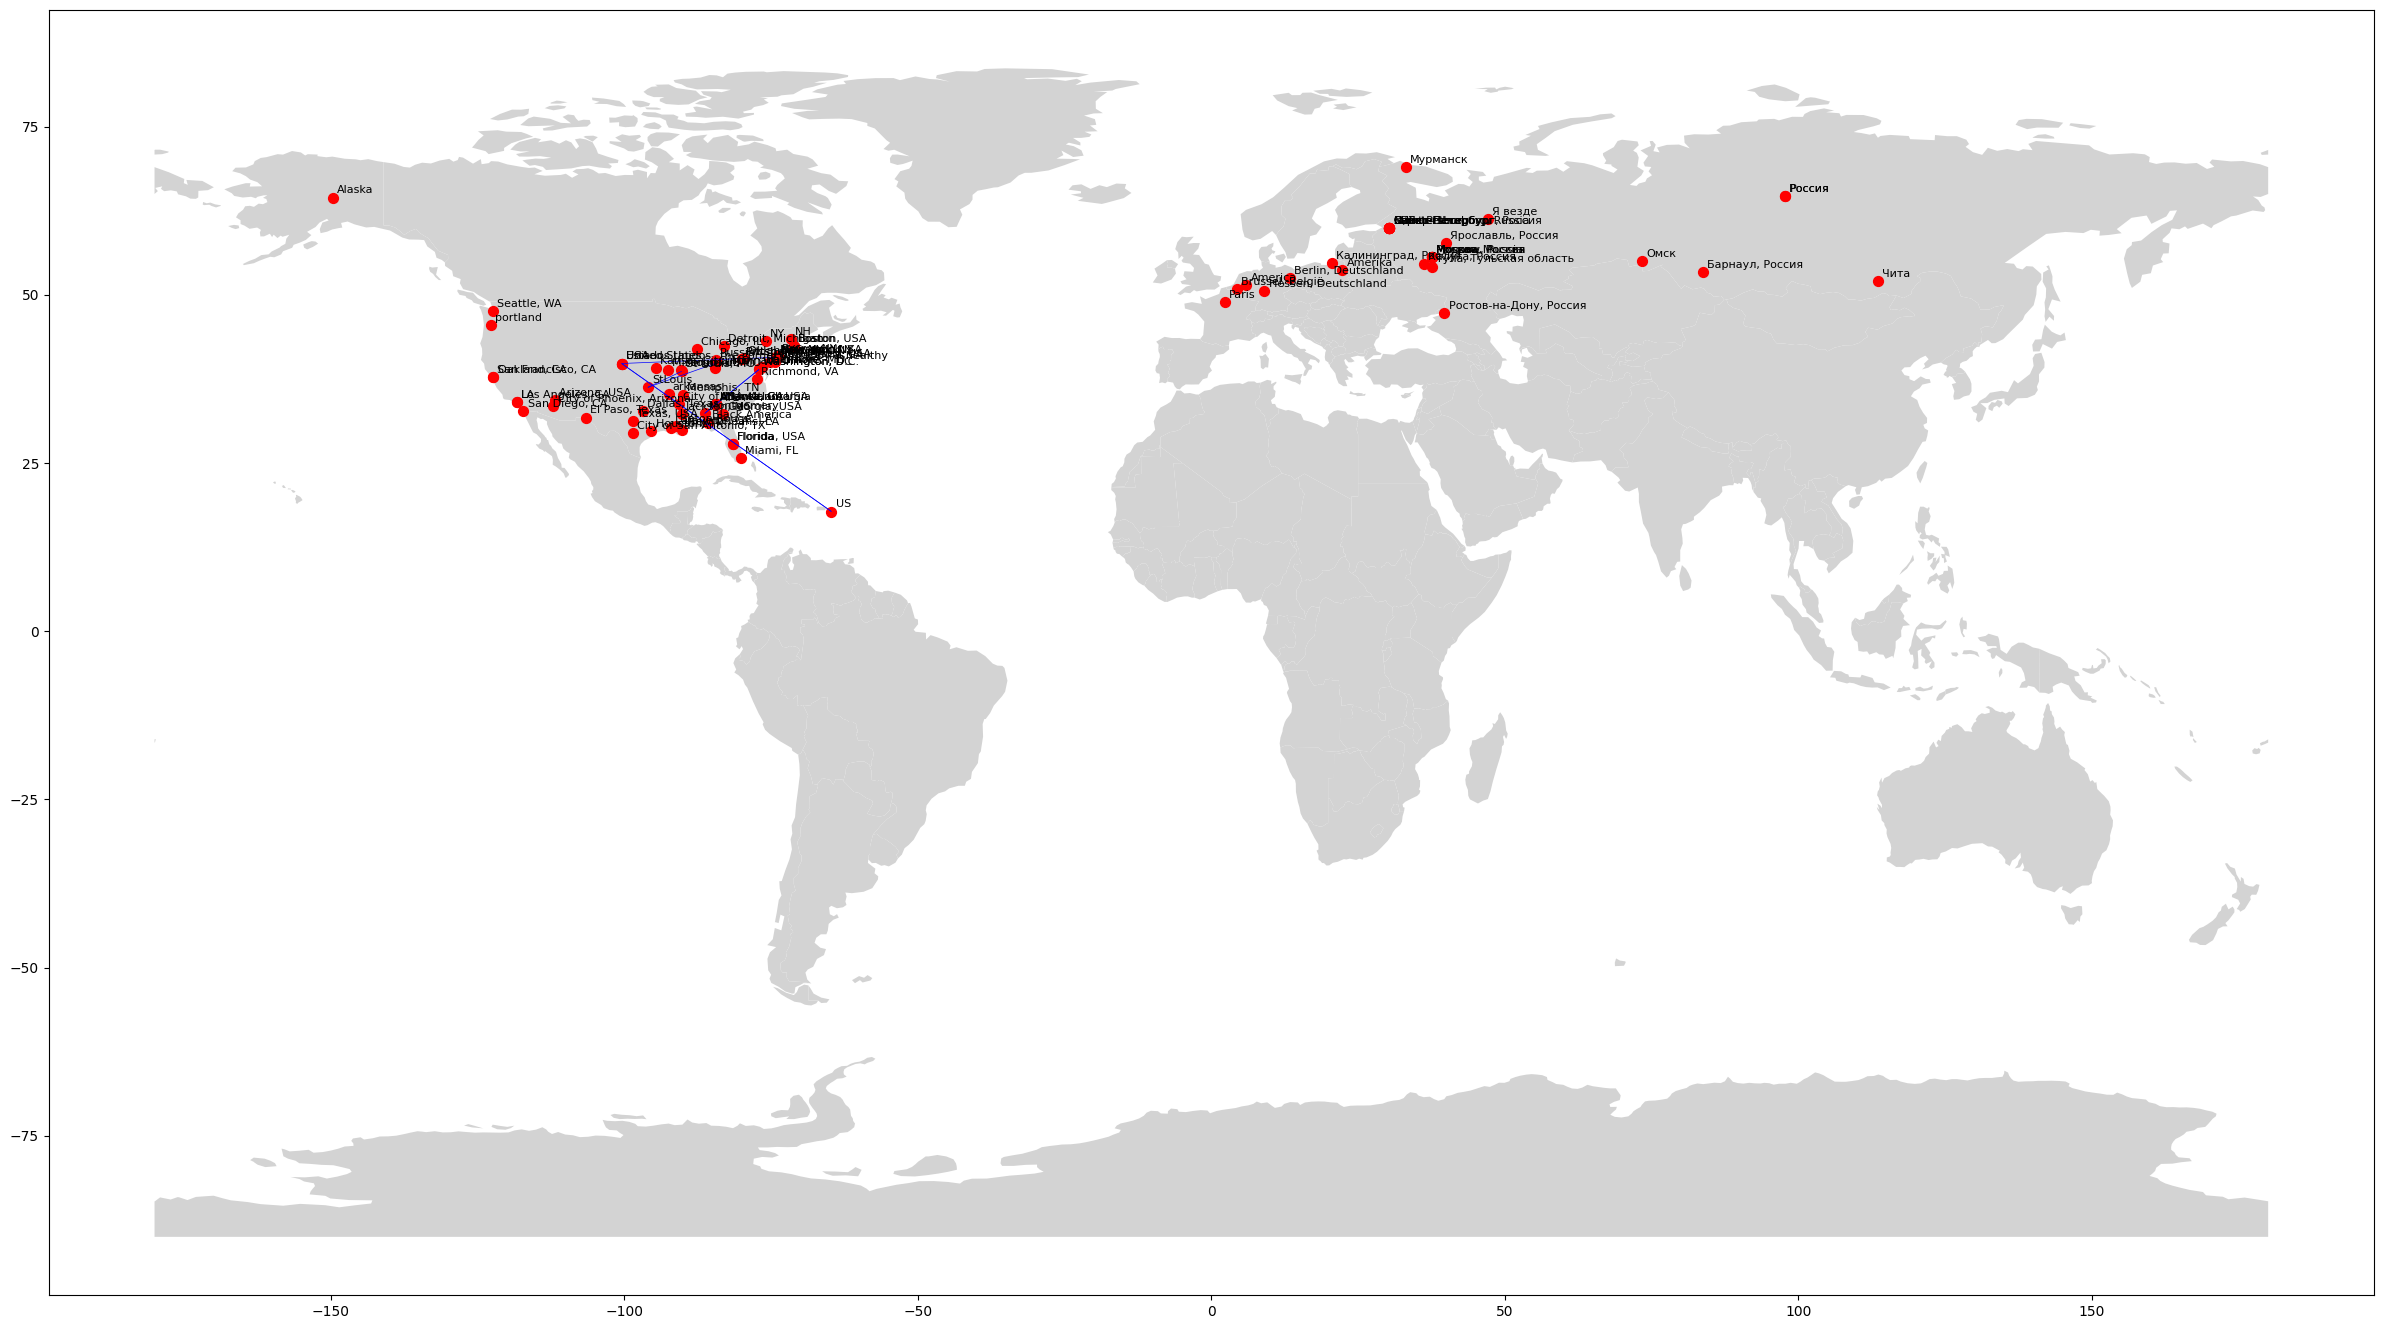

In [198]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import pandas as pd


cities = {
    user_location.iloc[i]['location']: user_location.iloc[i]['coordinates']
    for i in range(len(user_location)) if user_location.iloc[i]['coordinates'] is not None
}

# Convert coordinates to Point objects
geometry = [Point(lon, lat) for lat, lon in cities.values()]

# Create a GeoDataFrame for cities
gdf_cities = gpd.GeoDataFrame(geometry=geometry, index=cities.keys(), crs='EPSG:4326')

# Load world map data
world = gpd.read_file('./shapes/ne_110m_admin_0_countries.shp')

# Plot world map
world.plot(figsize=(30, 22), color='lightgrey')

# Plot city coordinates
gdf_cities.plot(ax=plt.gca(), marker='o', color='red', markersize=50)

# Read edges from CSV file
edges_df = pd.read_csv('data/edges.csv')

# Filter edges connecting nodes present in user_location
filtered_edges = edges_df[edges_df['Node1'].isin(user_location['user_key']) & edges_df['Node2'].isin(user_location['user_key'])]
# Create a GeoDataFrame for edges
edges_geometry = [LineString([Point(user_location.loc[user_location['user_key'] == node1, 'coordinates'].iloc[0][::-1]),
                              Point(user_location.loc[user_location['user_key'] == node2, 'coordinates'].iloc[0][::-1])])
                  for node1, node2 in zip(filtered_edges['Node1'], filtered_edges['Node2'])]

gdf_edges = gpd.GeoDataFrame(geometry=edges_geometry, crs='EPSG:4326')

# Plot edges on the world map
gdf_edges.plot(ax=plt.gca(), color='blue', linewidth=0.5)

# Add city names as labels
for idx, row in gdf_cities.iterrows():
    plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(3, 3), textcoords='offset points', fontsize=8)

plt.show()


#### With communities

In [ ]:
merged_df.dropna(inplace=True)
merged_df['coordinates'] = merged_df['coordinates'].apply(eval)

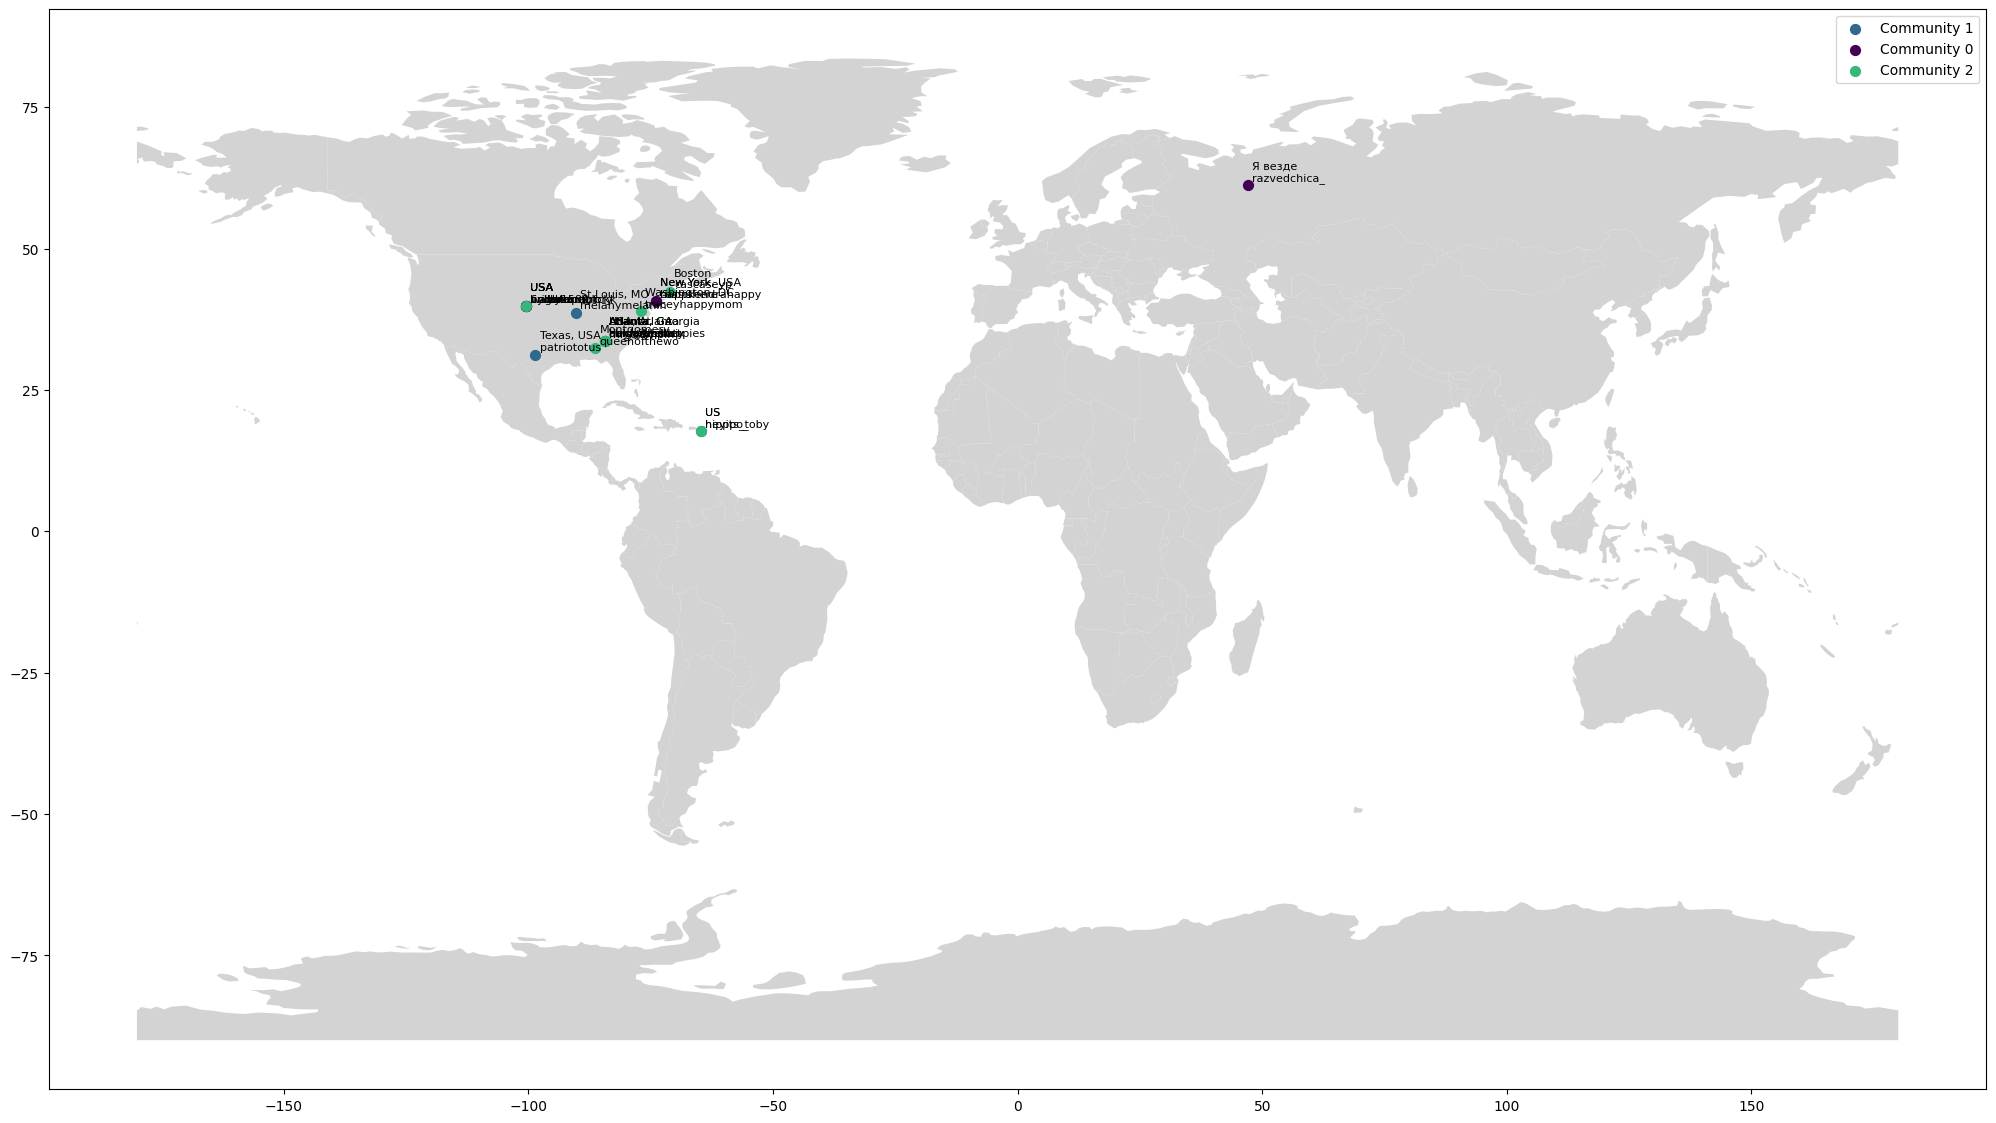

In [171]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np

merged_df['combined_index'] = merged_df['location'] + '_' + merged_df['user_key']

cities = {
    merged_df.iloc[i]['combined_index']: merged_df.iloc[i]['coordinates']
    for i in range(len(merged_df))
    if merged_df.iloc[i]['coordinates'] is not None
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in cities.values()], index=cities.keys(), crs='EPSG:4326')

# Load world map data
world = gpd.read_file('./shapes/ne_110m_admin_0_countries.shp')

# Merge GeoDataFrame with community information
gdf = gdf.merge(merged_df[['combined_index', 'community', 'location', 'user_key']], left_index=True, right_on='combined_index', how='left')

# Plot world map
world.plot(figsize=(25, 18), color='lightgrey')

# Plot city coordinates with colors based on the 'community' column
for community_id in gdf['community'].unique():
    subset = gdf[gdf['community'] == community_id]
    subset.plot(ax=plt.gca(), marker='o', color=plt.cm.viridis(community_id / len(gdf['community'].unique())), markersize=50, label=f'Community {community_id}')

# Add city names and user keys as labels
for _, row in gdf.iterrows():
    plt.annotate(f"{row['location']}\n{row['user_key']}", (row.geometry.x, row.geometry.y), xytext=(3, 3), textcoords='offset points', fontsize=8)

# Show legend
plt.legend()

plt.show()


# 3. User graph with pagerank values

In [25]:
import networkx as nx
import pandas as pd
# Create graph from edges

edges = pd.read_csv('data/edges.csv')
communities = pd.read_csv('data/communities.csv')
G = nx.from_pandas_edgelist(edges, source='Node1', target='Node2', create_using=nx.Graph)
# Don't allow self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Create a mapping of nodes to their respective communities
node_community_mapping = dict(zip(communities['id'], communities['community']))
colors = ['blue', 'orange', 'green']
# Extract communities and assign colors to nodes
node_colors = [colors[node_community_mapping[node]] if node in node_community_mapping else 'grey' for node in G.nodes]


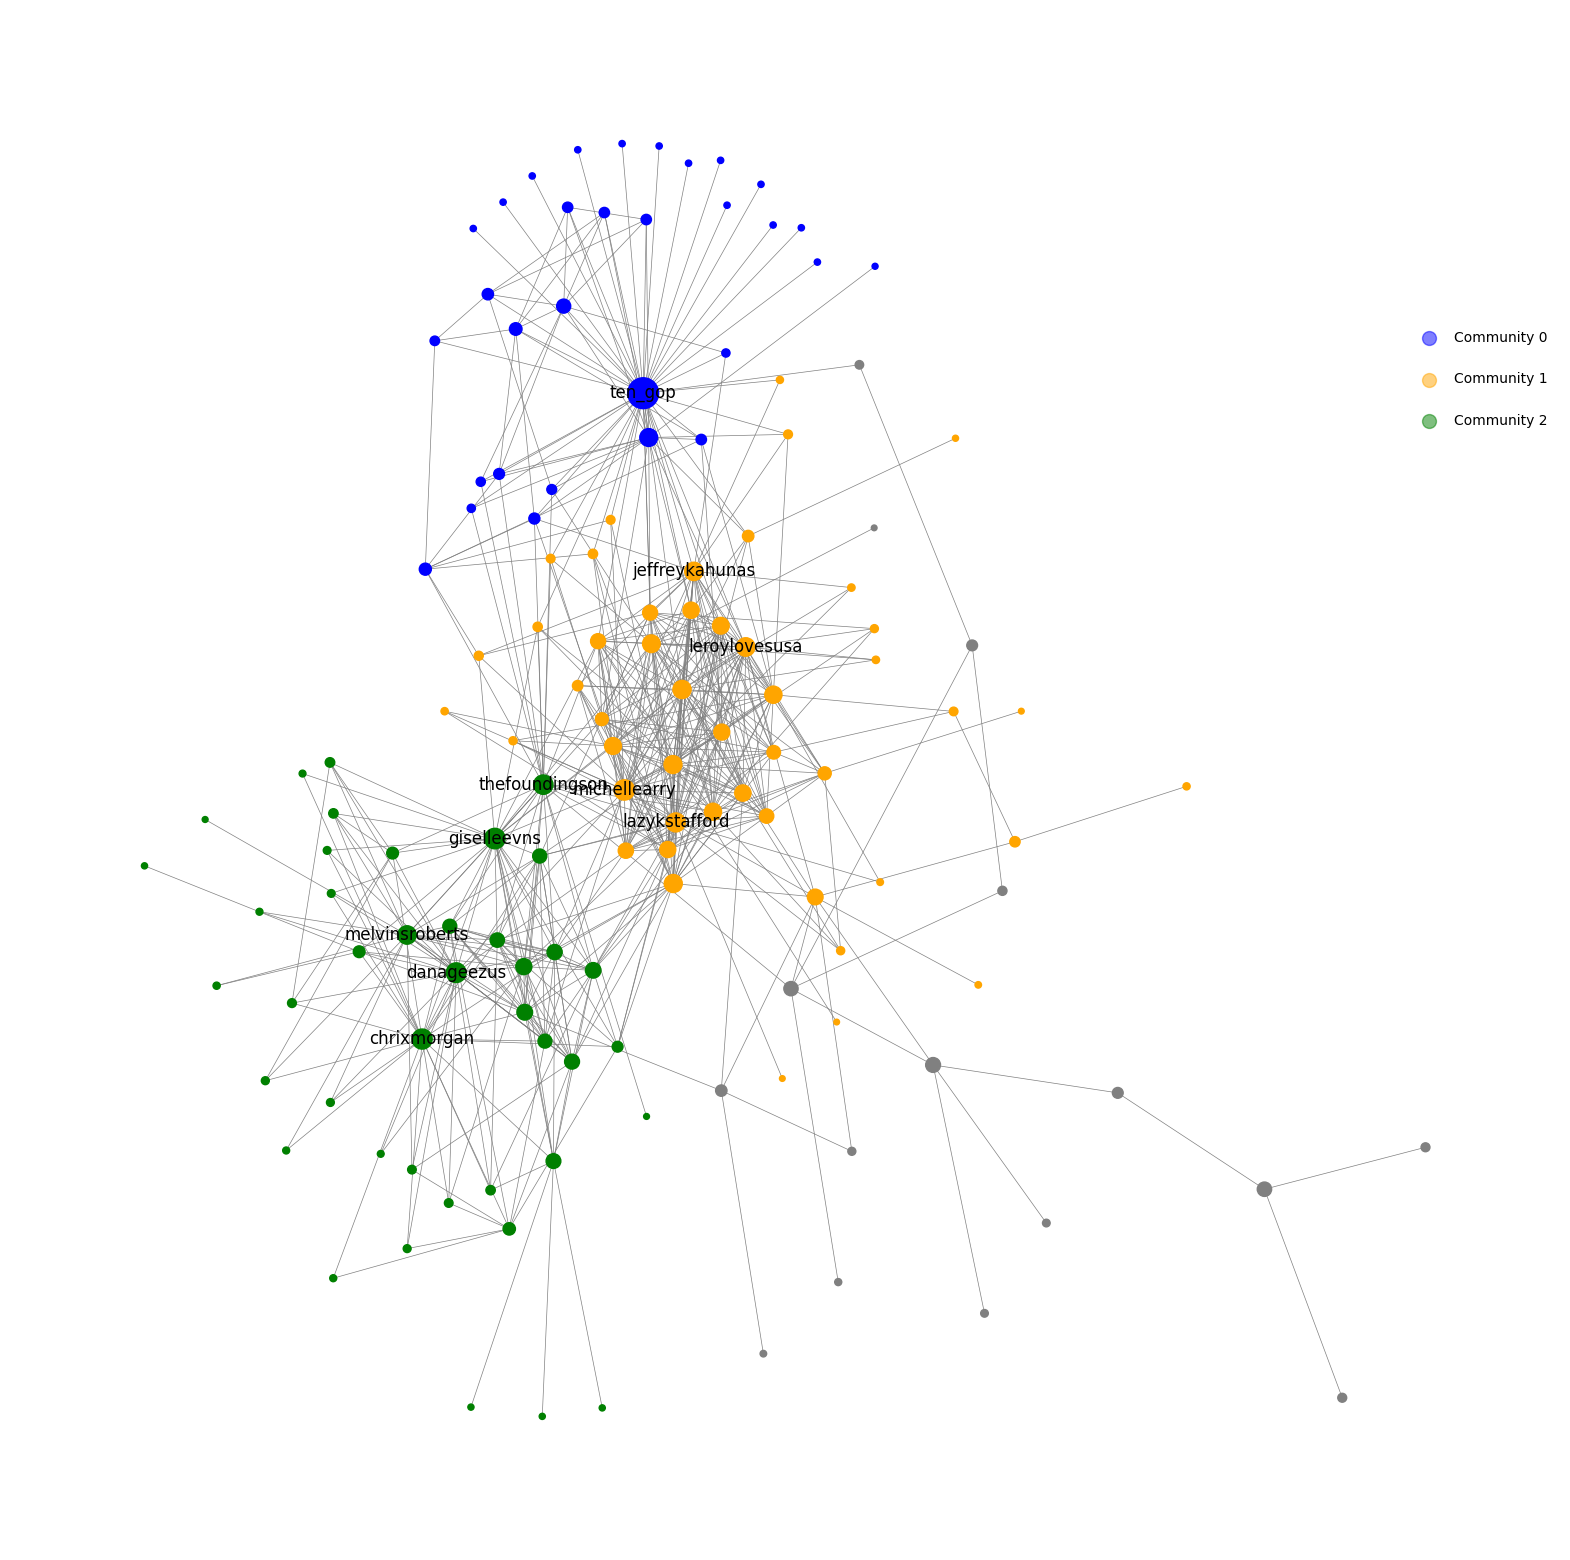

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# Assuming you have already defined G, pagerank, and pos
pagerank = nx.pagerank(G)
pos = nx.kamada_kawai_layout(G)

# Sort nodes by pagerank value in descending order
sorted_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Select top 20 nodes
top_nodes = dict(sorted_nodes[:10])

# Draw the graph with node sizes based on pagerank
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(G, node_size=[v * 10000 for v in pagerank.values()], with_labels=False, pos=pos, node_color=node_colors, edge_color='grey', ax=ax, width=0.5)

# Add labels only for the top 20 nodes using node names
nx.draw_networkx_labels(G, pos, labels={node: node for node in top_nodes}, font_size=12, font_color='black', font_family='sans-serif')
# add legend for community colors
for i, c in enumerate(colors):
    ax.scatter([], [], c=c, alpha=0.5, s=100, label=f'Community {i}')
ax.legend(scatterpoints=1, frameon=False, labelspacing=2, bbox_to_anchor=(1, 0.8))
# Display the graph
plt.show()


# 4. Histogram for degrees and pagerank

In [ ]:
np.arange()

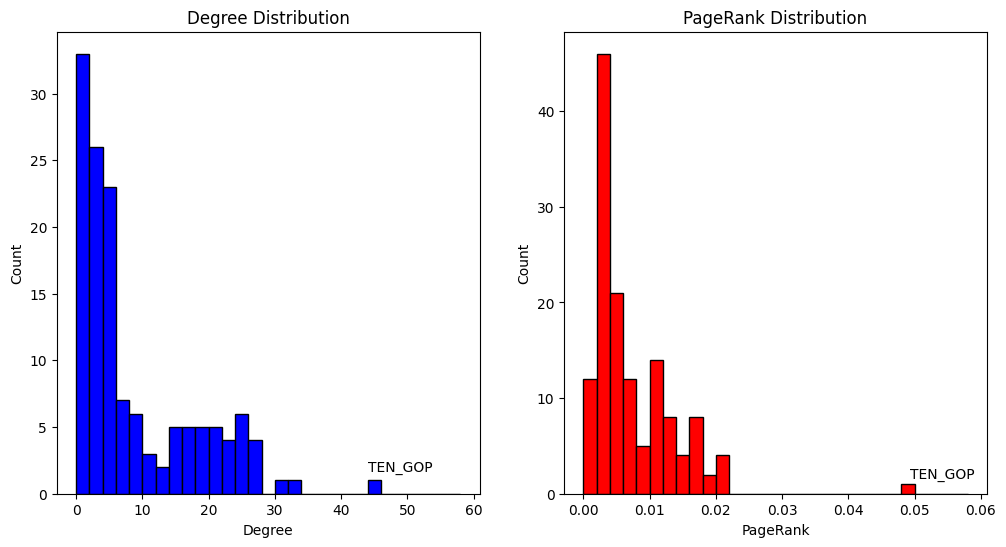

In [62]:
# histogram for G.degrees
import matplotlib.pyplot as plt
import numpy as np

degrees = [G.degree(node) for node in G.nodes]
pagerank = nx.pagerank(G)
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].hist(degrees, bins=np.arange(0, 60, 2), color='blue', edgecolor='black', linewidth=1.0)
ax[0].set_title('Degree Distribution')
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Count')

max_degree_node = max(G.nodes, key=G.degree)

# Add label to the top 1 record on the Degree Distribution histogram
ax[0].text(G.degree(max_degree_node), 2, f'{max_degree_node.upper()}', verticalalignment='center', color='black')

ax[1].hist(pagerank.values(), bins=np.arange(0, 0.06, 0.002), color='red', edgecolor='black', linewidth=1.0)
ax[1].set_title('PageRank Distribution')
ax[1].set_xlabel('PageRank')
ax[1].set_ylabel('Count')

max_pagerank_node = max(pagerank, key=pagerank.get)
# get second highest pagerank node
ax[1].text(pagerank[max_pagerank_node], 2, f'{max_pagerank_node.upper()}', verticalalignment='center', color='black')

plt.show()

# 5. Animation for user network